# Load Data

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', 500)

In [2]:
def load_df(csv_path='../data/raw/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
train_filepath = '../data/raw/train.csv'
test_filepath = '../data/raw/test.csv'

In [4]:
%%time
df_train = load_df(csv_path=train_filepath, nrows=20000)

Loaded train.csv. Shape: (20000, 54)
Wall time: 2.76 s


In [5]:
%%time
df_test = load_df(csv_path=test_filepath, nrows=20000)

Loaded test.csv. Shape: (20000, 53)
Wall time: 2.82 s


In [6]:
# df_train = pd.read_csv(train_filepath)
# df_train = pd.read_csv(test_filepath)

# Describe data

In [7]:
df_train.shape

(20000, 54)

In [8]:
df_train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available 

In [9]:
df_train.dtypes

channelGrouping                                      object
date                                                  int64
fullVisitorId                                        object
sessionId                                            object
socialEngagementType                                 object
visitId                                               int64
visitNumber                                           int64
visitStartTime                                        int64
device.browser                                       object
device.browserSize                                   object
device.browserVersion                                object
device.deviceCategory                                object
device.flashVersion                                  object
device.isMobile                                        bool
device.language                                      object
device.mobileDeviceBranding                          object
device.mobileDeviceInfo                 

# Data cleaning

In [10]:
# Convert total columns to float
float_columns = {}
for col in df_train.columns:
    if 'total' in col:
        float_columns[col] = float
        
df_train = df_train.astype(float_columns)

In [35]:
# Convert visitStartTime to datetime, drop date column that has the same information
# df_train['date'] = pd.to_datetime(df_train['date'], format='%Y%m%d')
df_train['visitStartTime'] = pd.to_datetime(df_train['visitStartTime'], unit='s')
df_train.drop('date', axis=1, inplace=True)

In [11]:
# Get number of unique and nulls for each column, add to delete list if 1 unique and 0 nulls
columns_to_drop = []
for col in df_train.columns:
    print(col)
    _nunique = df_train[col].nunique()
    _nnulls = df_train[col].isnull().sum()
    print('Unique: ',_nunique)
    print('Nulls: ',_nnulls)
    if (_nunique == 1) & (_nnulls == 0):
        columns_to_drop.append(col)
        print('Added to columns to drop')
    print('-' * 30)

channelGrouping
Unique:  7
Nulls:  0
------------------------------
date
Unique:  9
Nulls:  0
------------------------------
fullVisitorId
Unique:  18384
Nulls:  0
------------------------------
sessionId
Unique:  20000
Nulls:  0
------------------------------
socialEngagementType
Unique:  1
Nulls:  0
Added to columns to drop
------------------------------
visitId
Unique:  19668
Nulls:  0
------------------------------
visitNumber
Unique:  108
Nulls:  0
------------------------------
visitStartTime
Unique:  19668
Nulls:  0
------------------------------
device.browser
Unique:  25
Nulls:  0
------------------------------
device.browserSize
Unique:  1
Nulls:  0
Added to columns to drop
------------------------------
device.browserVersion
Unique:  1
Nulls:  0
Added to columns to drop
------------------------------
device.deviceCategory
Unique:  3
Nulls:  0
------------------------------
device.flashVersion
Unique:  1
Nulls:  0
Added to columns to drop
------------------------------
device

In [12]:
# Drop columns from columns_to_drop list
df_train.drop(columns_to_drop, axis=1, inplace=True)

In [13]:
# Show unique values of columns with null values
null_columns = df_train.columns[df_train.isnull().sum() > 0]
for col in null_columns:
    print(col)
    print(df_train[col].unique())
    print('-' * 30)

totals.bounces
[ 1. nan]
------------------------------
totals.newVisits
[ 1. nan]
------------------------------
totals.transactionRevenue
[        nan 3.78600e+07 3.06670e+08 6.80300e+07 2.62500e+07 5.74150e+08
 8.38000e+06 3.95730e+08 2.40800e+07 3.54800e+07 3.50800e+07 8.15000e+07
 5.46320e+08 6.38400e+07 1.17340e+08 4.37100e+07 3.44800e+07 3.53900e+07
 3.39030e+08 3.36700e+07 6.35500e+08 1.03240e+08 3.05470e+08 5.15000e+06
 9.08500e+07 1.05900e+07 2.56800e+07 3.38970e+08 5.93910e+08 4.47900e+07
 3.03900e+07 1.09900e+07 2.49900e+07 1.69700e+07 8.98000e+06 3.07200e+07
 1.19600e+07 5.75700e+07 2.29700e+07 2.36790e+08 1.79160e+08 8.07600e+07
 2.59370e+08 1.06260e+08 3.83500e+07 5.35600e+07 1.91170e+08 3.19800e+07
 6.47000e+07 9.67700e+07 2.64790e+08 1.05120e+08 1.07700e+09 2.98760e+08
 2.71800e+07 2.50000e+07 9.59700e+07 1.09150e+08 1.35900e+07 1.67900e+07
 6.99000e+06 1.13520e+08 7.48000e+06 1.32900e+07 3.00350e+08 3.39800e+07
 7.99900e+07 7.45900e+07 5.75800e+07 3.35800e+07 9.98000e

 '/spreadsheets/d/1Q6-xhf7qhp-GilI4AuaPwYLtqVZUMwIA9TFXcvka1RE/edit']
------------------------------


In [14]:
# Fill numeric columns with zero
for col in df_train.columns:
    if col in df_train._get_numeric_data().columns:
        print(col, ': Numeric')
        df_train[col] = df_train[col].fillna(0)
    else:
        print(col, ': Object')
        if col == 'trafficSource.adwordsClickInfo.isVideoAd':
            df_train[col] = df_train[col].fillna(True)
        elif col == 'trafficSource.isTrueDirect':
            df_train[col] = df_train[col].fillna(False)
        else:
            df_train[col] = df_train[col].fillna('unknown')

channelGrouping : Object
date : Numeric
fullVisitorId : Object
sessionId : Object
visitId : Numeric
visitNumber : Numeric
visitStartTime : Numeric
device.browser : Object
device.deviceCategory : Object
device.isMobile : Numeric
device.operatingSystem : Object
geoNetwork.city : Object
geoNetwork.continent : Object
geoNetwork.country : Object
geoNetwork.metro : Object
geoNetwork.networkDomain : Object
geoNetwork.region : Object
geoNetwork.subContinent : Object
totals.bounces : Numeric
totals.hits : Numeric
totals.newVisits : Numeric
totals.pageviews : Numeric
totals.transactionRevenue : Numeric
trafficSource.adContent : Object
trafficSource.adwordsClickInfo.adNetworkType : Object
trafficSource.adwordsClickInfo.gclId : Object
trafficSource.adwordsClickInfo.isVideoAd : Object
trafficSource.adwordsClickInfo.page : Object
trafficSource.adwordsClickInfo.slot : Object
trafficSource.campaign : Object
trafficSource.isTrueDirect : Object
trafficSource.keyword : Object
trafficSource.medium : Objec

# Data Exploration

In [15]:
import seaborn as sns
# import matplotlib
import matplotlib.pyplot as plt

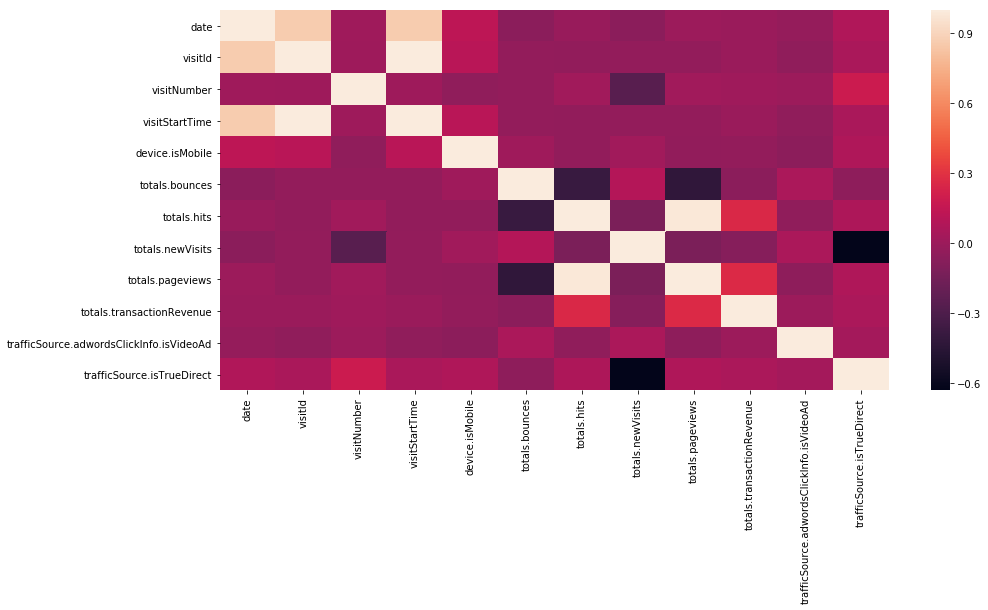

In [16]:
# Numeric correlations
plt.figure(figsize = (15,7))
sns.heatmap(df_train.corr())
plt.show()

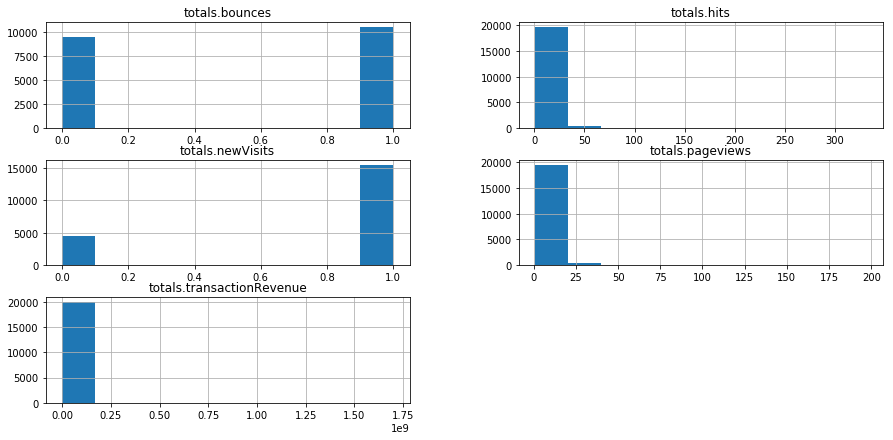

In [17]:
# Histograms
# plt.figure(figsize = (15,7))
df_train.select_dtypes(include=[float, int]).hist(figsize = (15,7))
plt.show()

In [18]:
# % of session with revenue
'{}% of total sessions has revenue'.format(((df_train['totals.transactionRevenue']>0).sum()/len(df_train))*100)

'1.24% of total sessions has revenue'

In [19]:
df_train['has_revenue'] = df_train['totals.transactionRevenue'] > 0

In [20]:
target_col = 'has_revenue'
N=20
i = 0
text = ''
for col in df_train.columns:
    if df_train[col].nunique() < N:
        i+=1
        text += '{}. Column: {}\n'.format(i,col)
        text += '\nNormalized by column:\n'
        text += str(pd.crosstab(df_train[col],df_train[target_col],normalize="columns"))
        text += '\nNormalized by index:\n'
        text += str(pd.crosstab(df_train[col],df_train[target_col],normalize="index"))
        text += '\nActuals:\n'
        text += str(pd.crosstab(df_train[col],df_train[target_col]))
        text += '\n\n'
print(text)

1. Column: channelGrouping

Normalized by column:
has_revenue         False     True 
channelGrouping                    
Affiliates       0.018783  0.000000
Direct           0.154870  0.125000
Display          0.008050  0.020161
Organic Search   0.440765  0.262097
Paid Search      0.029719  0.032258
Referral         0.110774  0.548387
Social           0.237039  0.012097
Normalized by index:
has_revenue         False     True 
channelGrouping                    
Affiliates       1.000000  0.000000
Direct           0.989968  0.010032
Display          0.969512  0.030488
Organic Search   0.992589  0.007411
Paid Search      0.986555  0.013445
Referral         0.941480  0.058520
Social           0.999360  0.000640
Actuals:
has_revenue      False  True 
channelGrouping              
Affiliates         371      0
Direct            3059     31
Display            159      5
Organic Search    8706     65
Paid Search        587      8
Referral          2188    136
Social            4682      3

2

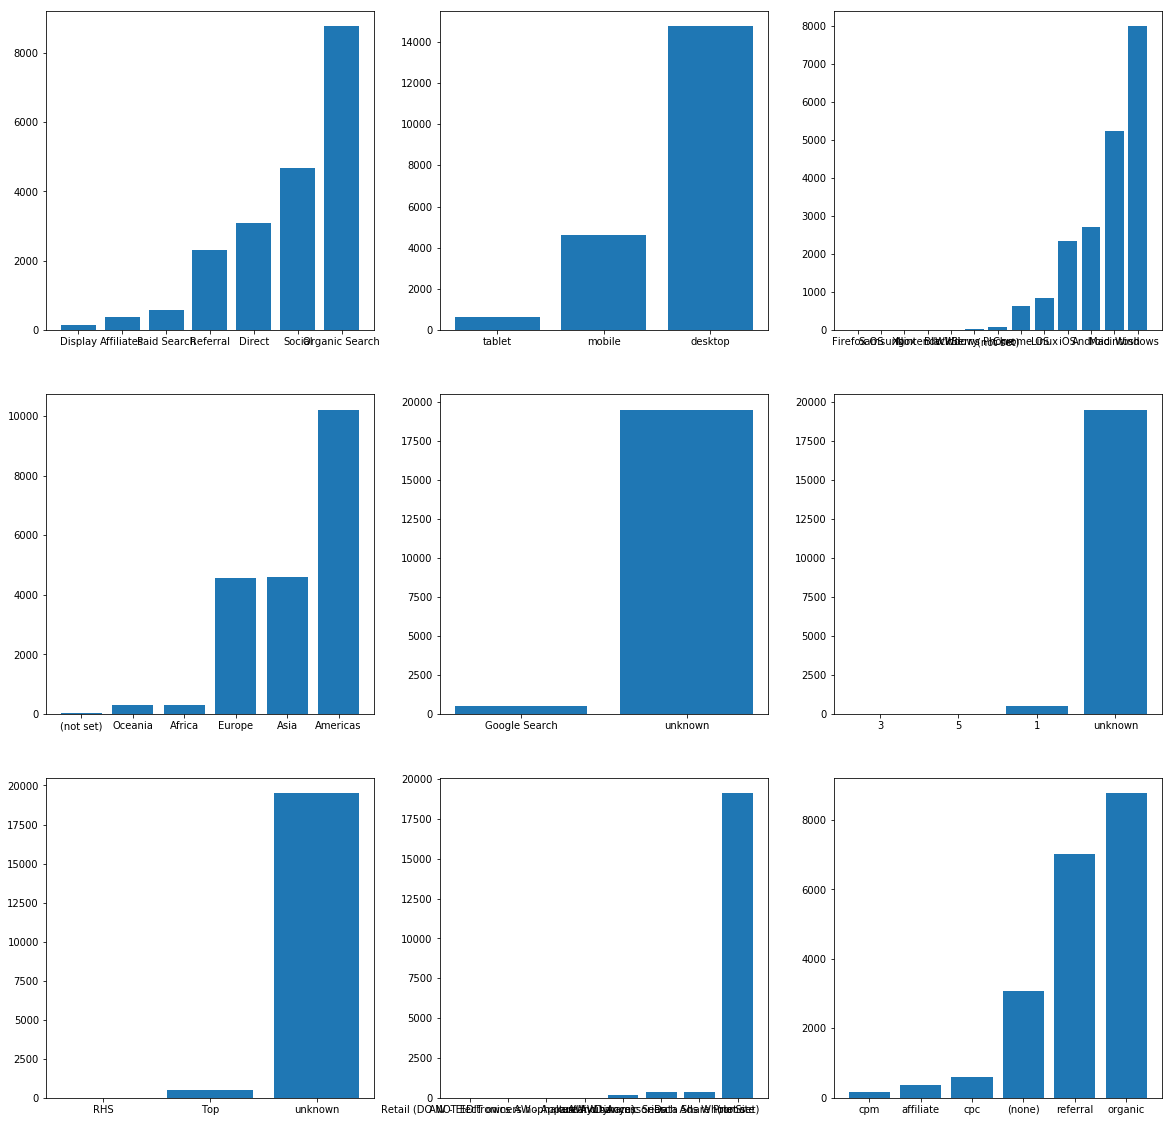

In [21]:
i = 0
fig = plt.figure(figsize=(20, 20))
for col in df_train.columns:
    if (df_train[col].dtype=='object') & (df_train[col].nunique() < 20):
        i += 1
        height = df_train.groupby(col)[col].count().sort_values()
        ax = plt.subplot(3, 3, i)
        plt.bar(height.index, height)

<pre>
Next steps:
- Convert date to datetime and create features
- Convert categoricals to numerial
- Convert numerical to bins
- Split train/test
- Predict revenue
- Predict future revenue